In [1]:
# 雲端硬碟授權
from google.colab import drive
drive.mount('/content/gdrive') # 此處需登入google帳號

Mounted at /content/gdrive


Found 1714 images belonging to 15 classes.
Found 150 images belonging to 15 classes.
Epoch 1/50
26/26 [==============================] - 11s 296ms/step - loss: 1.0038 - accuracy: 0.7630 - val_loss: 0.2418 - val_accuracy: 0.9922
Epoch 2/50
26/26 [==============================] - 8s 290ms/step - loss: 0.2638 - accuracy: 0.9418 - val_loss: 0.1020 - val_accuracy: 1.0000
Epoch 3/50
26/26 [==============================] - 8s 294ms/step - loss: 0.1861 - accuracy: 0.9582 - val_loss: 0.0768 - val_accuracy: 0.9922
Epoch 4/50
26/26 [==============================] - 7s 276ms/step - loss: 0.1564 - accuracy: 0.9564 - val_loss: 0.0614 - val_accuracy: 0.9922
Epoch 5/50
26/26 [==============================] - 8s 299ms/step - loss: 0.1339 - accuracy: 0.9648 - val_loss: 0.0550 - val_accuracy: 0.9922
Epoch 6/50
26/26 [==============================] - 8s 312ms/step - loss: 0.1186 - accuracy: 0.9651 - val_loss: 0.0492 - val_accuracy: 1.0000
Epoch 7/50
26/26 [==============================] - 7s 272ms/s

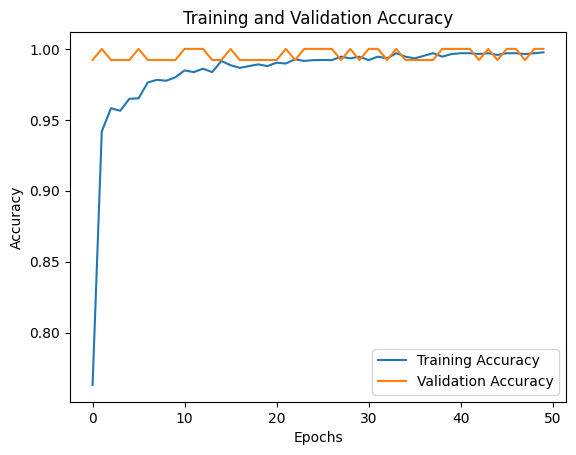

3/3 [==============================] - 1s 133ms/step - loss: 0.0285 - accuracy: 1.0000
Validation Accuracy: 100.00%


In [6]:
# Fine_Turning_Xception

import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.applications import Xception

# 定義圖片資料路徑
train_data_dir = '/content/gdrive/My Drive/70_dog/train'
valid_data_dir = '/content/gdrive/My Drive/70_dog/valid'
test_data_dir = '/content/gdrive/My Drive/70_dog/test'

# 定義圖片資料維度與批次大小
img_width, img_height = 150, 150
batch_size = 64

# 題目指定品種
classes = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie",
           "Dingo", "French Bulldog", "German Sheperd", "Malinois", "Newfoundland",
           "Pekinese", "Pomeranian", "Pug", "Vizsla"]

# 建立圖形資料生成器以進行資料加強,提高模型之泛化能力及穩定性
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# 訓練資料從資料生成器中讀取
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    classes = classes,  # 僅取指定品種
    class_mode = 'categorical'  # 解決圖像分類問題,故使用categorical
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    classes = classes,  # 僅取指定品種
    class_mode = 'categorical'  # 解決圖像分類問題,故使用categorical
)

# 加載Xception模型,因圖片為彩色,故input_shape中通道數設為3
base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

# 將Xception模型各層設為不可訓練
for layer in base_model.layers:
    layer.trainable = False

# 在頂部添加新的全連接層
model = Sequential()
model.add(base_model) # 將Xception設為基礎模型
model.add(Flatten())  # 將圖像轉為一維數組讓dense層處理
model.add(Dense(128, activation = 'relu'))
model.add(Dense(len(classes), activation = 'softmax'))  # 輸出層

# 編譯模型,因題目為多類別分類問題,故loss函數採categorical_crossentropy
model.compile(optimizer = SGD(learning_rate=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
training = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = 50,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples // batch_size
)

# 繪製訓練與驗證準確率隨Epochs的變化圖
plt.plot(training.history['accuracy'], label = 'Training Accuracy')
plt.plot(training.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 評估模型
scores = model.evaluate(valid_generator)
print("Validation Accuracy: %.2f%%" % (scores[1]*100))

# 依指定路徑儲存模型
folder_path = '/content/gdrive/My Drive/70_dog/fine turning'
os.makedirs(folder_path ,exist_ok=True) # 創建資料夾
model.save(folder_path)

In [7]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf

# 載入模型
model = tf.keras.models.load_model('/content/gdrive/My Drive/70_dog/fine turning')


# 輸入testing資料
image_folder = '/content/gdrive/My Drive/70_dog/70_dog_testing_set'

# 獲取資料夾內所有圖片路徑
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')]

# 將資料夾內圖片轉為與模型相符格式
input_images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = image.resize((150, 150))
    image = np.array(image) / 255.0
    input_images.append(image)

# 將圖片轉為numpy格式
input_images = np.array(input_images)

# 使用模型進行預測
predictions = model.predict(input_images)

# 指定類別
class_names = ["Airedale", "Beagle", "Bloodhound", "Bluetick", "Chihuahua", "Collie",
           "Dingo", " French Bulldog", " German Sheperd", " Malinois", " Newfoundland",
           " Pekinese", " Pomeranian", "Pug", "Vizsla"]

# 提取預測結果
predicted_classes = []
for prediction in predictions:
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    predicted_classes.append(predicted_class)

# 提取各圖片之檔名
image_file_names = [os.path.basename(image_path) for image_path in image_paths]

# 將結果依格式儲存
data = {'檔名': image_file_names, '結果': predicted_classes}
df = pd.DataFrame(data)

# 將結果儲存至test_data.xlsx
output_file = '/content/gdrive/My Drive/70_dog/fine turning/test_data.xlsx'
df.to_excel(output_file, index=False)


10/10 [==============================] - 2s 65ms/step
